# Project - Optimal Sperating Hyperplane 


## Introduction
This project aims to demonstrate how to find an optimal separating hyperplane for a set of points that are linearly separable. We explore different models, including ones with no loss function, hinge loss, and ramp loss, using the Mixed Integer Linear Programming (MiP) library in Python.

## Data Preparation
First, we generate 16 random points and assign labels to create a linearly separable dataset.


In [101]:
import random as r
import matplotlib.pyplot as plt
import mip
import pandas as pd

r.seed(42)

points = [(r.randint(-100, 100), r.randint(-100, 100)) for i in range(16)]
points.sort()
labels = [-1]*8 + [1]*8

#store results in a dict 
hyperplane = {"Model": [], "w":[], "b": []}

print(points)

[(-94, 89), (-92, -93), (-77, -45), (-43, -65), (-41, 29), (-30, -38), (7, -44), (39, -78), (43, -50), (51, 8), (54, -94), (63, -72), (73, 89), (79, 39), (83, 66), (88, -74)]


## Visualizing the Data

We plot the generated points to visualize the dataset's linear separability.

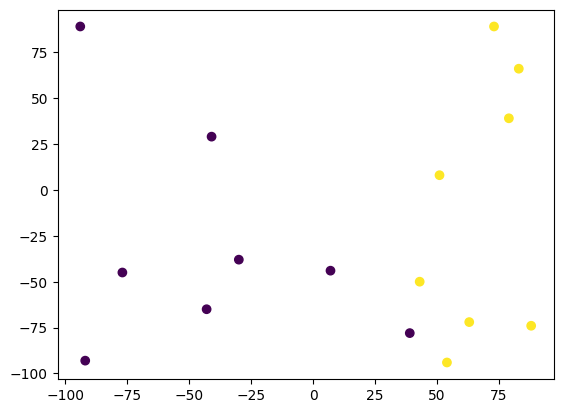

In [102]:
fig, ax = plt.subplots()

ax.scatter([p[0] for p in points], [p[1] for p in points], c=labels)

## Model Setup

We define the model using the MIP library, setting up variables for weights, bias, and, where applicable, errors for handling the loss functions.

### No Loss Fucntion


In [103]:
#model linarly separable
labels = [-1]*8 + [1]*8


model = mip.Model()

# Variables
w = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(2)]  # Weights
b = model.add_var(var_type=mip.CONTINUOUS)  # Bias
beta_ = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(2)]  # Weights


# Adding constraints for linear separability
for point, label in zip(points, labels):
    model += (mip.xsum(w[i] * point[i] for i in range(2)) + b)*label >= 1

model += beta_[0] >= w[0]
model += beta_[0] >= -w[0]
model += beta_[1] >= w[1]
model += beta_[1] >= -w[1]


# Placeholder Objective: Minimize bias to ensure a solution is found that separates the points
model.objective = mip.minimize(mip.xsum(beta_[i] for i in range(2)))

model.optimize()

# Extracting model parameters
w_opt = [w[i].x for i in range(2)]
b_opt = b.x

print(f"Optimal w: {w_opt}")
print(f"Optimal b: {b_opt}")

# Displaying the equation of the hyperplane
print(f"The equation of the separating hyperplane is: {w_opt[0]}*x + {w_opt[1]}*y + {b_opt} = 0")



Optimal w: [0.3150183150183153, 0.17032967032967047]
Optimal b: 0.0
The equation of the separating hyperplane is: 0.3150183150183153*x + 0.17032967032967047*y + 0.0 = 0


In [104]:
hyperplane["Model"].append("No Loss function")
hyperplane["w"].append(w_opt)
hyperplane["b"].append(b_opt)


### Visualisation of the Separating Hyperplane without Loss Function

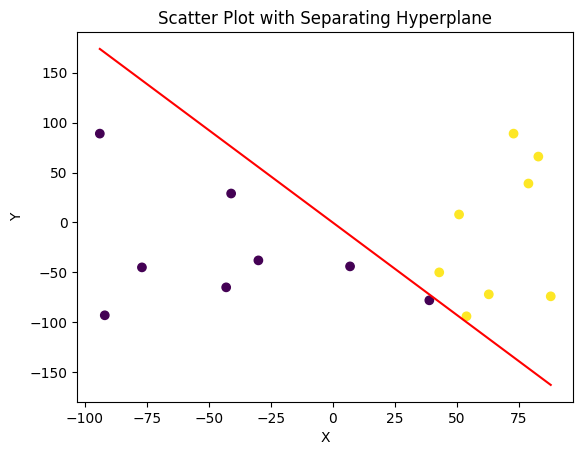

In [105]:
plt.scatter([p[0] for p in points], [p[1] for p in points], c=labels)

# Determine the range of x values
x_min = min([p[0] for p in points])
x_max = max([p[0] for p in points])

# Check if w_opt[1] is zero to avoid division by zero
if hyperplane["w"][0][1] == 0:
    # Plot vertical line if w_opt[1] is zero
    x_line = -hyperplane["b"][0] / hyperplane["w"][0][0]
    plt.axvline(x=x_line, color='r')
else:
    # Calculate y values for the hyperplane across the x range
    x_values = [x_min, x_max]
    y_values = [(-hyperplane["b"][0] - hyperplane["w"][0][0] * x) / hyperplane["w"][0][1] for x in x_values]
    plt.plot(x_values, y_values, 'r')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Separating Hyperplane')
plt.show()




### Hinge Loss

We implement a model with hinge loss, introducing error variables to manage points within the margin. The hinge loss function is pivotal in Support Vector Machine (SVM) models for maximizing the margin between different classes. It is mathematically defined as:

$$L = \max(0, 1 - t \cdot y)$$

In this formula, \(t\) represents the true label of a data point, which can either be -1 or 1, and \(y\) is the predicted value derived from the model's weights and bias. The function penalizes predictions that either fall on the wrong side of the decision boundary or are too close to it. This encourages the model to not only separate the classes with a hyperplane but also to ensure that this hyperplane is as far as possible from the closest points of both classes, effectively maximizing the margin.

To accommodate this in our model, error variables are introduced. These variables measure the extent to which each point does not fulfill the margin requirement. During the optimization process, the model aims to minimize these errors, leading to a maximization of the margin between the classes.


In [111]:
#flip the sign of 4 points to simulate a non lineary sperable model. 
labels[4] = 1
labels[6] = 1
labels[9] = -1
labels[10] = -1

In [107]:
#Hinge loss
model = mip.Model()
  
C = 1 

# Variables
w = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(2)]  # Weights
b = model.add_var(var_type=mip.CONTINUOUS)  # Bias
beta_ = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(2)]  # Weights
errors = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(len(points))]  # errors

# Adding constraints for linear separability
for point, label, e in zip(points, labels, errors):
    model += (mip.xsum(w[i] * point[i] for i in range(2)) + b)*label >= 1 - e

model += beta_[0] >= w[0]
model += beta_[0] >= -w[0]
model += beta_[1] >= w[1]
model += beta_[1] >= -w[1]


# Placeholder Objective: Minimize bias to ensure a solution is found that separates the points
model.objective = mip.minimize(mip.xsum(beta_[i] for i in range(2))) + C *  mip.xsum(errors[i] for i in range(len(points)))

model.optimize()

# Extracting model parameters
w_opt = [w[i].x for i in range(2)]
b_opt = b.x

print(f"Optimal w: {w_opt}")
print(f"Optimal b: {b_opt}")

# Displaying the equation of the hyperplane
print(f"The equation of the separating hyperplane is: {w_opt[0]}*x + {w_opt[1]}*y + {b_opt} = 0")

hyperplane["Model"].append("Hinge Loss")
hyperplane["w"].append(w_opt)
hyperplane["b"].append(b_opt)

Optimal w: [0.020346042934956746, 0.010253123998718357]
Optimal b: 0.0
The equation of the separating hyperplane is: 0.020346042934956746*x + 0.010253123998718357*y + 0.0 = 0


### Ramp Loss

Following the implementation with hinge loss, we extend our model to include ramp loss. Similar to hinge loss, ramp loss aims to manage misclassifications and margin violations. However, it introduces a capped loss value, adding a novel twist to how errors are penalized. The ramp loss function can be described as:

$$L = \min(\max(0, 1 - t \cdot y), cap)$$

Here, \(t\) denotes the true label of a data point, with possible values of -1 or 1, \(y\) represents the predicted value determined by the model, and \(cap\) is a predefined cap value that limits the maximum loss for any data point. This formulation ensures that while predictions that fall on the wrong side of the decision boundary or are too close to it are penalized, there is an upper limit to this penalty. The cap \(cap\) prevents outliers or points significantly far from the decision boundary from disproportionately influencing the model's parameters.

In our implementation, we adapt the model to reflect ramp loss by introducing modifications to handle the capping mechanism effectively. This involves the use of binary variables in combination with continuous error variables to ensure that the loss for each point is properly capped at \(cap\), aligning with the ramp loss definition. This adjustment aims to strike a balance between penalizing misclassifications and maintaining robustness to outliers, thereby fostering the development of a more generalizable model.


In [108]:
#Ramp Loss
model = mip.Model()
  
C = 1 
cap_c = 1.5  # Define the cap value for the ramp loss


# Variables
w = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(2)]  # Weights
b = model.add_var(var_type=mip.CONTINUOUS)  # Bias
beta_ = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(2)]  # Weights
errors = [model.add_var(var_type=mip.CONTINUOUS) for _ in range(len(points))]  # errors
is_capped = [model.add_var(var_type=mip.BINARY) for _ in range(len(points))]  # Binary variables for capping


# Adding constraints for linear separability
for point, label, e, is_cap in zip(points, labels, errors, is_capped):
    model += (mip.xsum(w[i] * point[i] for i in range(2)) + b)*label >= 1 - e
    model += e <= cap_c * is_cap
    model += e <= cap_c
    model += e >= 1 - (mip.xsum(w[j] * point[j] for j in range(2)) + b) * label - (1 - is_cap) * cap_c


model += beta_[0] >= w[0]
model += beta_[0] >= -w[0]
model += beta_[1] >= w[1]
model += beta_[1] >= -w[1]


# Placeholder Objective: Minimize bias to ensure a solution is found that separates the points
model.objective = mip.minimize(mip.xsum(beta_[i] for i in range(2))) + C *  mip.xsum(errors[i] for i in range(len(points)))

model.optimize()

# Extracting model parameters
w_opt = [w[i].x for i in range(2)]
b_opt = b.x

print(f"Optimal w: {w_opt}")
print(f"Optimal b: {b_opt}")

# Displaying the equation of the hyperplane
print(f"The equation of the separating hyperplane is: {w_opt[0]}*x + {w_opt[1]}*y + {b_opt} = 0")

hyperplane["Model"].append("Ramp Loss")
hyperplane["w"].append(w_opt)
hyperplane["b"].append(b_opt)

Optimal w: [0.009228824273072062, 0.0036662452591656124]
Optimal b: 0.0
The equation of the separating hyperplane is: 0.009228824273072062*x + 0.0036662452591656124*y + 0.0 = 0


### Summary of the equation found

In [109]:
pd.DataFrame(hyperplane)

,Model,w,b
0,No Loss function,"[0.3150183150183153, 0.17032967032967047]",0.0
1,Hinge Loss,"[0.020346042934956746, 0.010253123998718357]",0.0
2,Ramp Loss,"[0.009228824273072062, 0.0036662452591656124]",0.0


### Visualisation of the Hinge Loss and the Ramp Loss

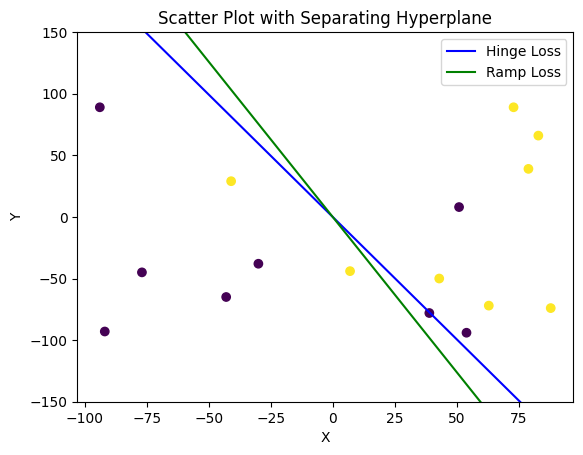

 The graph illustrates that the hyperplane derived using ramp loss more effectively optimizes the margin between the two classes' support vectors, compared to the hinge loss approach. 


In [113]:
plt.scatter([p[0] for p in points], [p[1] for p in points], c=labels)

# Determine the range of x values
x_min = min([p[0] for p in points])
x_max = max([p[0] for p in points])

# Check if w_opt[1] is zero to avoid division by zero
if hyperplane["w"][0][1] == 0:
    # Plot vertical line if w_opt[1] is zero
    # #no loss function
    # x_line_noloss = -hyperplane["b"][0] / hyperplane["w"][0][0]
    # plt.axvline(x=x_line_noloss, color='r')

    #hinge loss
    x_line_hinge = -hyperplane["b"][1] / hyperplane["w"][1][0]
    plt.axvline(x=x_line_hinge, color='b')

    #ramp loss
    x_line_ramp = -hyperplane["b"][2] / hyperplane["w"][2][0]
    plt.axvline(x=x_line_ramp, color='g')
else:
    # Calculate y values for the hyperplane across the x range
    x_values = [x_min, x_max]
    # #no loss
    # y_values_noloss = [(-hyperplane["b"][0] - hyperplane["w"][0][0] * x) / hyperplane["w"][0][1] for x in x_values]
    # plt.plot(x_values, y_values_noloss, 'r')
    
    #hinge loss
    y_values_hing = [(-hyperplane["b"][2] - hyperplane["w"][1][0] * x) / hyperplane["w"][1][1] for x in x_values]
    plt.plot(x_values, y_values_hing, 'b', label="Hinge Loss")

    #ramp loss
    y_values_ramp = [(-hyperplane["b"][1] - hyperplane["w"][2][0] * x) / hyperplane["w"][2][1] for x in x_values]
    plt.plot(x_values, y_values_ramp, 'g', label="Ramp Loss")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Separating Hyperplane')
plt.ylim(-150, 150)
plt.legend()
plt.show()

print(""" The graph illustrates that the hyperplane derived using ramp loss more effectively optimizes the margin between the two classes' support vectors, compared to the hinge loss approach. """)